In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
%cd /content/drive/MyDrive/Research/Cifar

/content/drive/MyDrive/Research/Cifar


In [21]:
#@title (Run) Part 1: Define required functions for Data processing

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch import Tensor
import os
import argparse
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

def balance_val_split(dataset, train_size=12500):

    try:
        targets = np.array(dataset.targets)
    except:
        targets = []  # create an empty list to store the targets
        for data in dataset.datasets:
            targets += data.targets  # concatenate the targets from each dataset into the list
        targets = np.array(targets)
    #targets = np.array(dataset.datasets.targets)
    train_indices, val_indices = train_test_split(
        np.arange(targets.shape[0]),
        train_size=train_size,
        stratify=targets
    )
    train_dataset = Subset(dataset, indices=train_indices)
    # Get the data from the subset dataset
    subset_data = [train_dataset[idx][0] for idx in range(len(train_dataset))]
    subset_labels = [train_dataset[idx][1] for idx in range(len(train_dataset))]
    # Create a dataset from the list of data and targets
    train_dataset = MyDataset(subset_data, subset_labels)
    
    
    val_dataset = Subset(dataset, indices=val_indices)
    # Get the data from the subset dataset
    subset_data = [val_dataset[idx][0] for idx in range(len(val_dataset))]
    subset_labels = [val_dataset[idx][1] for idx in range(len(val_dataset))]
    # Create a dataset from the list of data and targets
    val_dataset = MyDataset(subset_data, subset_labels)

    return train_dataset, val_dataset


def count_label_frequency(target_train_dataset):
	from collections import Counter
	target_labels = []  # create an empty list to store the labels

	for i in range(len(target_train_dataset)):
			_, label = target_train_dataset[i]  # extract the label for the i-th example in the subset
			target_labels.append(label)  # append the label to the 'subset_labels' list


	return Counter(target_labels)
 


def custom_transform(image: Tensor) -> Tensor:
    import random
    # randomly flip horizontally or vertically with 25% chance
    if random.random() < 0.25:
        image = RandomHorizontalFlip(p=1)(image)
    elif random.random() < 0.5:
        image = RandomVerticalFlip(p=1)(image)
    
    # randomly shift the image by 2 pixels to the left or right with 25% chance
    if random.random() < 0.25:
        image = RandomCrop((image.shape[-2], image.shape[-1] - 2), pad_if_needed=False)(image)
    elif random.random() < 0.5:
        image = RandomCrop((image.shape[-2], image.shape[-1] + 2), pad_if_needed=False)(image)
        
    # randomly shift the image by 2 pixels to the top or bottom with 25% chance
    if random.random() < 0.25:
        image = RandomCrop((image.shape[-2] - 2, image.shape[-1]), pad_if_needed=False)(image)
    elif random.random() < 0.5:
        image = RandomCrop((image.shape[-2] + 2, image.shape[-1]), pad_if_needed=False)(image)

    return image

In [22]:
#@title (Run) Part 2: Define required functions for Data Training

# Training
def train(trainloader, epoch, batch_size=128, logfile = "train.summary"):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        #inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        if inputs.shape[0] != batch_size:
          print(inputs.shape)
          continue
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(net.parameters(), 10)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 30 == 0:
                print(batch_idx, len(trainloader), 'Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print(len(trainloader), 'Epoch: %d | Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                     % (epoch, train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    f = open(logfile, "a")
    f.write('Epoch: %d | Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)\n'
                     % (epoch, train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    f.close()

def test(testloader, epoch, batch_size=128, logfile = "train.summary", save_modelpath = './DLA'):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0



    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            #inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 30 == 0:
                print(batch_idx, len(testloader), 'Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print(len(testloader), 'Epoch: %d | Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                         % (epoch, test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    f = open(logfile, "a")
    f.write('Epoch: %d | Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)\n'
                         % (epoch, test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    f.close()
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(save_modelpath):
            os.mkdir(save_modelpath)
        torch.save(state, save_modelpath+'/ckpt.pth')
        best_acc = acc

def draw_training_summary(filepath = 'target_train_DCA-BiLSTM.summary'):
    import matplotlib.pyplot as plt
    import numpy as np

    with open(filepath, 'r') as f:
        results_summary = f.read()

    train_epoch = []
    train_loss = []
    train_acc = []
    test_epoch = []
    test_loss=[]
    test_acc=[]
    for line in results_summary.split("\n"):
        try:
            r_epoch = line.split('|')[0].strip().split(' ')[1]
            r_loss = line.split('|')[1].strip().split(' ')[2].replace('%','')
            r_acc = line.split('|')[2].strip().split(' ')[2].replace('%','')
            if 'Train' in line:
                train_epoch.append(int(r_epoch))
                train_loss.append(float(r_loss))
                train_acc.append(float(r_acc))
            if 'Test' in line:
                test_epoch.append(int(r_epoch))
                test_loss.append(float(r_loss))
                test_acc.append(float(r_acc))
        except:
            print(line)

    # Create a new figure and plot the data
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(train_acc, label='Train')
    plt.plot(test_acc, label='Test')
    plt.axhline(y=np.max(test_acc), color='r', linestyle='--')
    # Add text for the horizontal line
    plt.text(test_epoch[-10], np.max(test_acc)*1.05, np.max(test_acc), color='r', fontsize=10)
    # Customize the plot
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_loss, label='Train')
    plt.plot(test_loss, label='Test')

    # Customize the plot
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()



    # Display the plot
    plt.show()

In [23]:
#@title (Run) Part 3: Prepare Cifar10 dataset for target and shadow model
import pickle
from torch.utils.data import DataLoader
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def create_cifar_dataset_torch(load_data = False, batch_size=128, target_train_size = 15000, target_test_size= 15000, shadow_train_size = 15000, shadow_test_size= 15000):

  # Data
  print('==> Preparing data..')
  if not load_data:

      transform = transforms.Compose([
            transforms.ToTensor()
        ])

      cifar_trainset = torchvision.datasets.CIFAR10(
          root='./data', train=True, download=True, transform=transform)


      cifar_testset = torchvision.datasets.CIFAR10(
          root='./data', train=False, download=True, transform=transform)

      cifar_dataset = torch.utils.data.ConcatDataset([cifar_trainset, cifar_testset])


      #target_train_size = int(0.25 * len(cifar_dataset)) # 15000
      remain_size = len(cifar_dataset) - target_train_size
      target_train_dataset, remain_dataset = torch.utils.data.random_split(cifar_dataset, [target_train_size, remain_size])

      #target_test_size = int(0.25 * len(cifar_dataset)) # 15000
      remain_size = len(remain_dataset) - target_test_size
      target_test_dataset, remain_dataset = torch.utils.data.random_split(remain_dataset, [target_test_size, remain_size])

      #target_test_dataset, remain_dataset = balance_val_split(remain_dataset, train_size=target_test_size)


      #shadow_train_size = int(0.25 * len(cifar_dataset)) # 15000
      remain_size = len(remain_dataset) - shadow_train_size
      shadow_train_dataset, shadow_test_dataset = torch.utils.data.random_split(remain_dataset, [shadow_train_size, remain_size])
      #shadow_train_dataset, shadow_test_dataset = balance_val_split(remain_dataset, train_size=shadow_train_size)

      print("Setting target_train_dataset size to ",len(target_train_dataset), count_label_frequency(target_train_dataset))
      print("Setting target_test_dataset size to ",len(target_test_dataset), count_label_frequency(target_test_dataset))
      print("Setting shadow_train_dataset size to ",len(shadow_train_dataset), count_label_frequency(shadow_train_dataset))
      print("Setting shadow_test_dataset size to ",len(shadow_test_dataset), count_label_frequency(shadow_test_dataset))
      #print("Setting testset size to ",len(testset))



      '''
      transform_train = transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])
      '''



      transform_train = transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          custom_transform,
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])

      transform_test = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
      ])

      # apply the data augmentation transformations to the subset
      target_train_dataset.dataset.transform = transform_train
      # Load the transformed subset using a DataLoader
      target_trainloader = DataLoader(target_train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)


      target_test_dataset.dataset.transform = transform_test
      # Load the transformed subset using a DataLoader
      target_testloader = DataLoader(target_test_dataset, batch_size=batch_size, shuffle=True, drop_last = True)


      # apply the data augmentation transformations to the subset
      shadow_train_dataset.dataset.transform = transform_train
      # Load the transformed subset using a DataLoader
      shadow_trainloader = DataLoader(shadow_train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)


      shadow_test_dataset.dataset.transform = transform_test
      # Load the transformed subset using a DataLoader
      shadow_testloader = DataLoader(shadow_test_dataset, batch_size=batch_size, shuffle=True, drop_last = True)

      pickle.dump(target_trainloader, open('target_trainloader_VGG.p', 'wb'))
      pickle.dump(target_testloader, open('target_testloader_VGG.p', 'wb'))
      pickle.dump(shadow_trainloader, open('shadow_trainloader_VGG.p', 'wb'))
      pickle.dump(shadow_testloader, open('shadow_test_dataset_VGG.p', 'wb'))
    
  data_file = open('target_trainloader_VGG.p', 'rb')
  target_trainloader = pickle.load(data_file)
  data_file.close()
  data_file = open('target_testloader_VGG.p', 'rb')
  target_testloader = pickle.load(data_file)
  data_file.close()
  data_file = open('shadow_trainloader_VGG.p', 'rb')
  shadow_trainloader = pickle.load(data_file)
  data_file.close()
  data_file = open('shadow_test_dataset_VGG.p', 'rb')
  shadow_testloader = pickle.load(data_file)
  data_file.close()


  return target_trainloader, target_testloader, shadow_trainloader, shadow_testloader


In [24]:
#@title (Run) Part 4.3: Define required functions for VGG

'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name, num_classes=10, enable_RNN='LSTM'):
        super(VGG, self).__init__()
        
        
        self.enable_RNN = enable_RNN
        if enable_RNN not in ['None', 'LSTM', 'Bi-LSTM']:
          raise Exception("enable_RNN only supports one of ['None', 'LSTM', 'Bi-LSTM']")
        
        
        self.features = self._make_layers(cfg[vgg_name])
        
        
        if enable_RNN == 'None':
          self.linear = nn.Linear(512, num_classes)
        elif enable_RNN == 'LSTM':
          self.rnn = nn.LSTM(512, 1024, dropout = 0.6)
          self.linear = nn.Linear(1024, num_classes)
        elif enable_RNN == 'Bi-LSTM':
          self.rnn = nn.LSTM(512, 2048, 1, dropout = 0.3, batch_first=True, bidirectional=True)
          self.linear = nn.Linear(4096, num_classes)
        else:
          raise Exception("enable_RNN only supports one of ['None', 'LSTM', 'Bi-LSTM']")


    def forward(self, x):
        out = self.features(x)
        
        if self.enable_RNN == 'None':
          out = out.view(out.size(0), -1)
          out = self.linear(out)
        else:
          # add LSTM
          #print(out.shape)
          out = out.view(out.size(0), 1,  -1)
          out,_ = self.rnn(out)
          out = out.view(out.size(0), -1)
          out = self.linear(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


In [25]:
#@title (Run) Part 5.3.1: Select an architecture for Target model training
#from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: VGG
#@markdown * Option 2: VGG-LSTM
#@markdown * Option 3: VGG-BiLSTM


method_name = 'VGG-BiLSTM'  #@param {type:"string"}
save_model_folder = './Target-VGG-BiLSTM_models/'   #@param {type:"string"}
batch_size = 64  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}


print('==> Building model for ' + method_name)
if method_name == 'VGG-BiLSTM':
  # Model
  
  net = VGG('VGG11', enable_RNN='Bi-LSTM')
  net.cuda()
elif method_name == 'VGG-LSTM':
  # Model
  
  net = VGG('VGG11', enable_RNN='LSTM')
  net.cuda()
elif method_name == 'VGG':
  # Model
  
  net = VGG('VGG11', enable_RNN='None')
  net.cuda()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
if load_pretrain_weight:
  try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(save_model_folder+'/ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
  except:
      print('!!! Error: no checkpoint directory found!')
else:
  print('==> Training model from scratch..')
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trained parameters: ",pytorch_total_params)


==> Building model for VGG-BiLSTM
==> Training model from scratch..
Total trained parameters:  51242762


In [26]:
#@title (Run) Part 5.1.2: Setup Target and Shadow datasets for ReNet Training

target_train_size = 15000 #@param {type:"integer"}
target_test_size= 15000 #@param {type:"integer"}
shadow_train_size = 15000  #@param {type:"integer"} 
shadow_test_size= 15000 #@param {type:"integer"}

# create dataset for renet 
print('==> Preparing dataset..')
target_trainloader, target_testloader, shadow_trainloader, shadow_testloader = create_cifar_dataset_torch(load_data=True,batch_size=batch_size, target_train_size = target_train_size, target_test_size= target_test_size, shadow_train_size = shadow_train_size, shadow_test_size= shadow_test_size)

==> Preparing dataset..
==> Preparing data..


In [27]:
#@title (Run) Part 5.2.3: Start Target model training

max_epoch = 30  #@param {type:"integer"}
train_result_summary = 'target_train_VGG-BiLSTM.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(target_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(target_testloader, epoch, batch_size=batch_size, logfile = train_result_summary, save_modelpath = save_model_folder)
    #scheduler.step()


Epoch: 0
0 234 Train Loss: 2.299 | Train Acc: 9.375% (6/64)
30 234 Train Loss: 2.140 | Train Acc: 22.127% (439/1984)
60 234 Train Loss: 1.959 | Train Acc: 27.357% (1068/3904)
90 234 Train Loss: 1.854 | Train Acc: 30.804% (1794/5824)
120 234 Train Loss: 1.768 | Train Acc: 34.298% (2656/7744)
150 234 Train Loss: 1.697 | Train Acc: 36.962% (3572/9664)
180 234 Train Loss: 1.650 | Train Acc: 38.795% (4494/11584)
210 234 Train Loss: 1.607 | Train Acc: 40.462% (5464/13504)
234 Epoch: 0 | Train Loss: 1.576 | Train Acc: 41.740% (6251/14976)
0 234 Test Loss: 1.084 | Test Acc: 57.812% (37/64)
30 234 Test Loss: 1.347 | Test Acc: 51.815% (1028/1984)
60 234 Test Loss: 1.363 | Test Acc: 50.615% (1976/3904)
90 234 Test Loss: 1.365 | Test Acc: 49.948% (2909/5824)
120 234 Test Loss: 1.359 | Test Acc: 50.155% (3884/7744)
150 234 Test Loss: 1.357 | Test Acc: 50.062% (4838/9664)
180 234 Test Loss: 1.356 | Test Acc: 50.155% (5810/11584)
210 234 Test Loss: 1.349 | Test Acc: 50.222% (6782/13504)
234 Epoch: 0

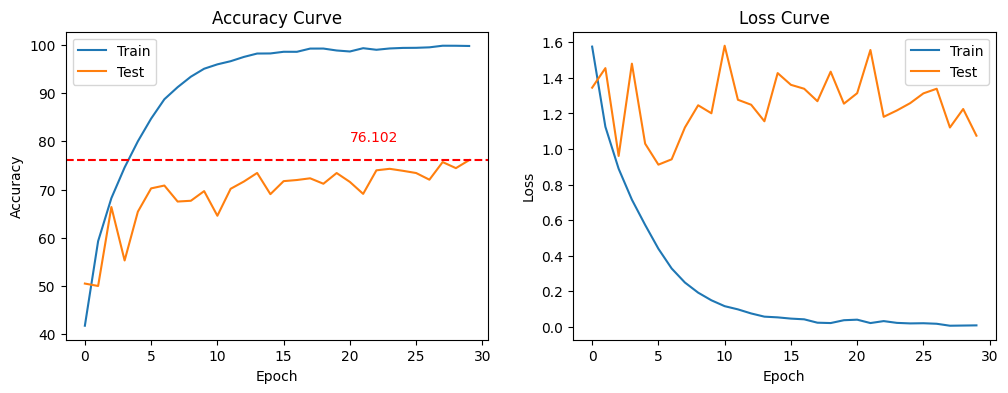

In [28]:
draw_training_summary(filepath = 'target_train_VGG-BiLSTM.summary')

In [29]:
#@title (Run) Part 5.3.1: Select an architecture for Target model training
#from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: VGG
#@markdown * Option 2: VGG-LSTM
#@markdown * Option 3: VGG-BiLSTM


method_name = 'VGG-BiLSTM'  #@param {type:"string"}
save_model_folder = './Shadow-VGG-BiLSTM_models/'   #@param {type:"string"}
batch_size = 64  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}


print('==> Building model for ' + method_name)
if method_name == 'VGG-BiLSTM':
  # Model
  
  net = VGG('VGG11', enable_RNN='Bi-LSTM')
  net.cuda()
elif method_name == 'VGG-LSTM':
  # Model
  
  net = VGG('VGG11', enable_RNN='LSTM')
  net.cuda()
elif method_name == 'VGG':
  # Model
  
  net = VGG('VGG11', enable_RNN='None')
  net.cuda()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
if load_pretrain_weight:
  try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(save_model_folder+'/ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
  except:
      print('!!! Error: no checkpoint directory found!')
else:
  print('==> Training model from scratch..')
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trained parameters: ",pytorch_total_params)


==> Building model for VGG-BiLSTM
==> Training model from scratch..
Total trained parameters:  51242762


In [30]:
#@title (Run) Part 5.2.3: Start Shadow model training

max_epoch = 30  #@param {type:"integer"}
train_result_summary = 'shadow_train_VGG-BiLSTM.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(shadow_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(shadow_testloader, epoch, batch_size=batch_size, logfile = train_result_summary, save_modelpath = save_model_folder)
    #scheduler.step()


Epoch: 0
0 234 Train Loss: 2.311 | Train Acc: 7.812% (5/64)
30 234 Train Loss: 2.140 | Train Acc: 21.270% (422/1984)
60 234 Train Loss: 1.935 | Train Acc: 28.074% (1096/3904)
90 234 Train Loss: 1.823 | Train Acc: 32.057% (1867/5824)
120 234 Train Loss: 1.736 | Train Acc: 35.382% (2740/7744)
150 234 Train Loss: 1.675 | Train Acc: 38.059% (3678/9664)
180 234 Train Loss: 1.611 | Train Acc: 40.478% (4689/11584)
210 234 Train Loss: 1.564 | Train Acc: 42.528% (5743/13504)
234 Epoch: 0 | Train Loss: 1.537 | Train Acc: 43.590% (6528/14976)
0 234 Test Loss: 2.163 | Test Acc: 29.688% (19/64)
30 234 Test Loss: 2.284 | Test Acc: 33.669% (668/1984)
60 234 Test Loss: 2.294 | Test Acc: 33.069% (1291/3904)
90 234 Test Loss: 2.281 | Test Acc: 32.847% (1913/5824)
120 234 Test Loss: 2.278 | Test Acc: 32.890% (2547/7744)
150 234 Test Loss: 2.277 | Test Acc: 32.916% (3181/9664)
180 234 Test Loss: 2.280 | Test Acc: 32.752% (3794/11584)
210 234 Test Loss: 2.282 | Test Acc: 32.620% (4405/13504)
234 Epoch: 0 

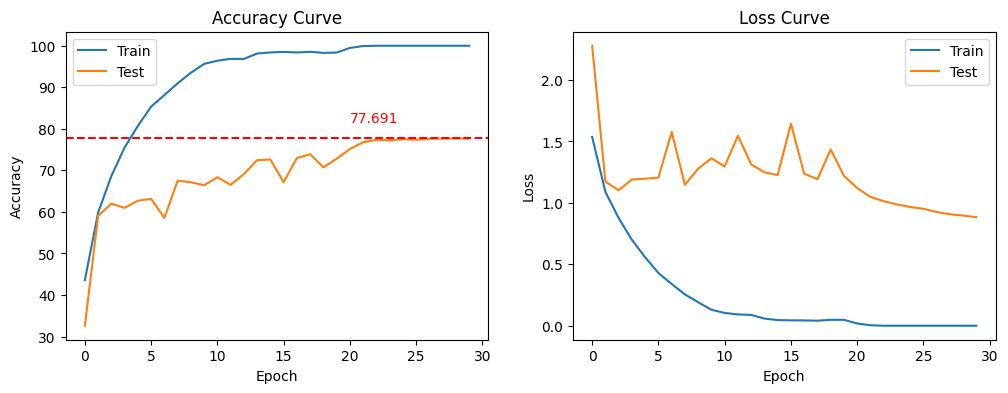

In [31]:
draw_training_summary(filepath = 'shadow_train_VGG-BiLSTM.summary')

In [32]:
#@title (Run) Part 5.3.1: Select an architecture for Target model training
#from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: VGG
#@markdown * Option 2: VGG-LSTM
#@markdown * Option 3: VGG-BiLSTM


method_name = 'VGG-LSTM'  #@param {type:"string"}
save_model_folder = './Target-VGG-LSTM_models/'   #@param {type:"string"}
batch_size = 64  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}


print('==> Building model for ' + method_name)
if method_name == 'VGG-BiLSTM':
  # Model
  
  net = VGG('VGG11', enable_RNN='Bi-LSTM')
  net.cuda()
elif method_name == 'VGG-LSTM':
  # Model
  
  net = VGG('VGG11', enable_RNN='LSTM')
  net.cuda()
elif method_name == 'VGG':
  # Model
  
  net = VGG('VGG11', enable_RNN='None')
  net.cuda()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
if load_pretrain_weight:
  try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(save_model_folder+'/ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
  except:
      print('!!! Error: no checkpoint directory found!')
else:
  print('==> Training model from scratch..')
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trained parameters: ",pytorch_total_params)


==> Building model for VGG-LSTM
==> Training model from scratch..
Total trained parameters:  15535882


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [33]:
#@title (Run) Part 5.2.3: Start Target model training

max_epoch = 30  #@param {type:"integer"}
train_result_summary = 'target_train_VGG-LSTM.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(target_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(target_testloader, epoch, batch_size=batch_size, logfile = train_result_summary, save_modelpath = save_model_folder)
    #scheduler.step()


Epoch: 0
0 234 Train Loss: 2.305 | Train Acc: 10.938% (7/64)
30 234 Train Loss: 2.166 | Train Acc: 20.716% (411/1984)
60 234 Train Loss: 1.985 | Train Acc: 27.331% (1067/3904)
90 234 Train Loss: 1.872 | Train Acc: 30.786% (1793/5824)
120 234 Train Loss: 1.788 | Train Acc: 33.639% (2605/7744)
150 234 Train Loss: 1.734 | Train Acc: 36.051% (3484/9664)
180 234 Train Loss: 1.683 | Train Acc: 38.096% (4413/11584)
210 234 Train Loss: 1.638 | Train Acc: 39.625% (5351/13504)
234 Epoch: 0 | Train Loss: 1.605 | Train Acc: 40.852% (6118/14976)
0 234 Test Loss: 1.866 | Test Acc: 32.812% (21/64)
30 234 Test Loss: 1.915 | Test Acc: 35.534% (705/1984)
60 234 Test Loss: 1.925 | Test Acc: 35.963% (1404/3904)
90 234 Test Loss: 1.934 | Test Acc: 35.251% (2053/5824)
120 234 Test Loss: 1.928 | Test Acc: 35.486% (2748/7744)
150 234 Test Loss: 1.934 | Test Acc: 35.286% (3410/9664)
180 234 Test Loss: 1.938 | Test Acc: 35.454% (4107/11584)
210 234 Test Loss: 1.937 | Test Acc: 35.412% (4782/13504)
234 Epoch: 0

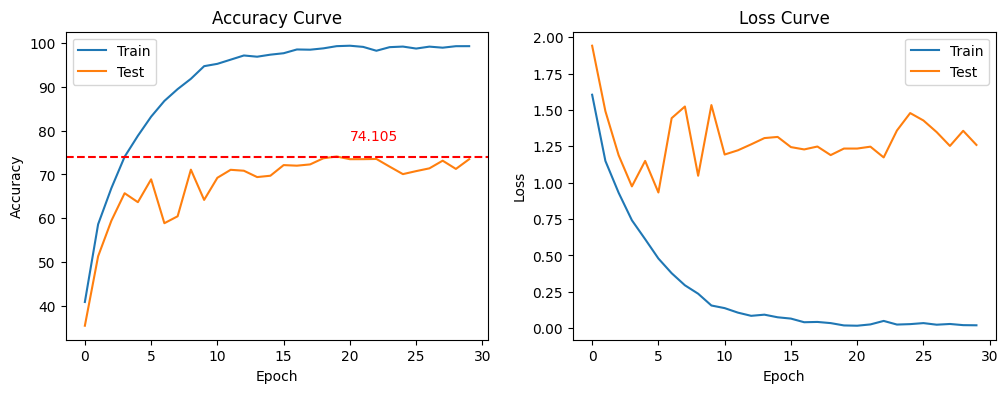

In [34]:
draw_training_summary(filepath = 'target_train_VGG-LSTM.summary')

In [35]:
#@title (Run) Part 5.3.1: Select an architecture for Target model training
#from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: VGG
#@markdown * Option 2: VGG-LSTM
#@markdown * Option 3: VGG-BiLSTM


method_name = 'VGG-LSTM'  #@param {type:"string"}
save_model_folder = './Shadow-VGG-LSTM_models/'   #@param {type:"string"}
batch_size = 64  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}


print('==> Building model for ' + method_name)
if method_name == 'VGG-BiLSTM':
  # Model
  
  net = VGG('VGG11', enable_RNN='Bi-LSTM')
  net.cuda()
elif method_name == 'VGG-LSTM':
  # Model
  
  net = VGG('VGG11', enable_RNN='LSTM')
  net.cuda()
elif method_name == 'VGG':
  # Model
  
  net = VGG('VGG11', enable_RNN='None')
  net.cuda()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
if load_pretrain_weight:
  try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(save_model_folder+'/ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
  except:
      print('!!! Error: no checkpoint directory found!')
else:
  print('==> Training model from scratch..')
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trained parameters: ",pytorch_total_params)


==> Building model for VGG-LSTM
==> Training model from scratch..
Total trained parameters:  15535882


In [38]:
#@title (Run) Part 5.2.3: Start Shadow model training

max_epoch = 30  #@param {type:"integer"}
train_result_summary = 'shadow_train_VGG-LSTM.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(shadow_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(shadow_testloader, epoch, batch_size=batch_size, logfile = train_result_summary, save_modelpath = save_model_folder)
    #scheduler.step()


Epoch: 0
0 234 Train Loss: 0.001 | Train Acc: 100.000% (64/64)
30 234 Train Loss: 0.001 | Train Acc: 99.950% (1983/1984)
60 234 Train Loss: 0.001 | Train Acc: 99.974% (3903/3904)
90 234 Train Loss: 0.001 | Train Acc: 99.983% (5823/5824)
120 234 Train Loss: 0.001 | Train Acc: 99.987% (7743/7744)
150 234 Train Loss: 0.001 | Train Acc: 99.990% (9663/9664)
180 234 Train Loss: 0.001 | Train Acc: 99.991% (11583/11584)
210 234 Train Loss: 0.001 | Train Acc: 99.993% (13503/13504)
234 Epoch: 0 | Train Loss: 0.001 | Train Acc: 99.993% (14975/14976)
0 234 Test Loss: 0.881 | Test Acc: 79.688% (51/64)
30 234 Test Loss: 1.040 | Test Acc: 76.966% (1527/1984)
60 234 Test Loss: 0.992 | Test Acc: 77.741% (3035/3904)
90 234 Test Loss: 0.998 | Test Acc: 77.438% (4510/5824)
120 234 Test Loss: 0.997 | Test Acc: 77.570% (6007/7744)
150 234 Test Loss: 1.004 | Test Acc: 77.142% (7455/9664)
180 234 Test Loss: 1.009 | Test Acc: 77.098% (8931/11584)
210 234 Test Loss: 1.018 | Test Acc: 77.096% (10411/13504)
234 

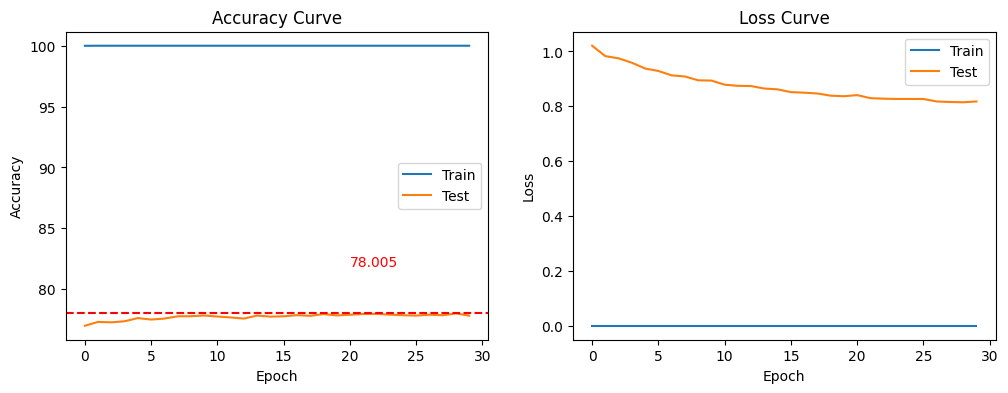

In [39]:
draw_training_summary(filepath = 'shadow_train_VGG-LSTM.summary')

In [40]:
#@title (Run) Part 5.3.1: Select an architecture for Target model training
#from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: VGG
#@markdown * Option 2: VGG-LSTM
#@markdown * Option 3: VGG-BiLSTM


method_name = 'VGG'  #@param {type:"string"}
save_model_folder = './Target-VGG_models/'   #@param {type:"string"}
batch_size = 64  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}


print('==> Building model for ' + method_name)
if method_name == 'VGG-BiLSTM':
  # Model
  
  net = VGG('VGG11', enable_RNN='Bi-LSTM')
  net.cuda()
elif method_name == 'VGG-LSTM':
  # Model
  
  net = VGG('VGG11', enable_RNN='LSTM')
  net.cuda()
elif method_name == 'VGG':
  # Model
  
  net = VGG('VGG11', enable_RNN='None')
  net.cuda()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
if load_pretrain_weight:
  try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(save_model_folder+'/ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
  except:
      print('!!! Error: no checkpoint directory found!')
else:
  print('==> Training model from scratch..')
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trained parameters: ",pytorch_total_params)


==> Building model for VGG
==> Training model from scratch..
Total trained parameters:  9231114


In [41]:
#@title (Run) Part 5.2.3: Start Target model training

max_epoch = 30  #@param {type:"integer"}
train_result_summary = 'target_train_VGG.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(target_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(target_testloader, epoch, batch_size=batch_size, logfile = train_result_summary, save_modelpath = save_model_folder)
    #scheduler.step()


Epoch: 0
0 234 Train Loss: 2.432 | Train Acc: 12.500% (8/64)
30 234 Train Loss: 2.171 | Train Acc: 24.496% (486/1984)
60 234 Train Loss: 2.049 | Train Acc: 28.842% (1126/3904)
90 234 Train Loss: 1.947 | Train Acc: 31.336% (1825/5824)
120 234 Train Loss: 1.855 | Train Acc: 34.181% (2647/7744)
150 234 Train Loss: 1.794 | Train Acc: 35.958% (3475/9664)
180 234 Train Loss: 1.737 | Train Acc: 37.750% (4373/11584)
210 234 Train Loss: 1.701 | Train Acc: 39.218% (5296/13504)
234 Epoch: 0 | Train Loss: 1.675 | Train Acc: 40.097% (6005/14976)
0 234 Test Loss: 1.291 | Test Acc: 46.875% (30/64)
30 234 Test Loss: 1.390 | Test Acc: 49.849% (989/1984)
60 234 Test Loss: 1.398 | Test Acc: 49.744% (1942/3904)
90 234 Test Loss: 1.416 | Test Acc: 49.691% (2894/5824)
120 234 Test Loss: 1.416 | Test Acc: 49.626% (3843/7744)
150 234 Test Loss: 1.414 | Test Acc: 49.379% (4772/9664)
180 234 Test Loss: 1.411 | Test Acc: 49.542% (5739/11584)
210 234 Test Loss: 1.411 | Test Acc: 49.385% (6669/13504)
234 Epoch: 0

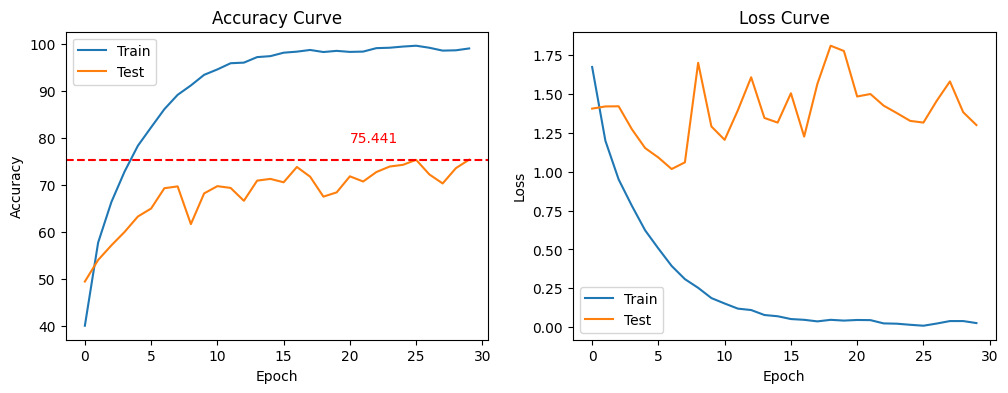

In [42]:
draw_training_summary(filepath = 'target_train_VGG.summary')

In [43]:
#@title (Run) Part 5.3.1: Select an architecture for Target model training
#from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: VGG
#@markdown * Option 2: VGG-LSTM
#@markdown * Option 3: VGG-BiLSTM


method_name = 'VGG'  #@param {type:"string"}
save_model_folder = './Shadow-VGG_models/'   #@param {type:"string"}
batch_size = 64  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}


print('==> Building model for ' + method_name)
if method_name == 'VGG-BiLSTM':
  # Model
  
  net = VGG('VGG11', enable_RNN='Bi-LSTM')
  net.cuda()
elif method_name == 'VGG-LSTM':
  # Model
  
  net = VGG('VGG11', enable_RNN='LSTM')
  net.cuda()
elif method_name == 'VGG':
  # Model
  
  net = VGG('VGG11', enable_RNN='None')
  net.cuda()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
if load_pretrain_weight:
  try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(save_model_folder+'/ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
  except:
      print('!!! Error: no checkpoint directory found!')
else:
  print('==> Training model from scratch..')
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trained parameters: ",pytorch_total_params)


==> Building model for VGG
==> Training model from scratch..
Total trained parameters:  9231114


In [44]:
#@title (Run) Part 5.2.3: Start Shadow model training

max_epoch = 30  #@param {type:"integer"}
train_result_summary = 'shadow_train_VGG.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(shadow_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(shadow_testloader, epoch, batch_size=batch_size, logfile = train_result_summary, save_modelpath = save_model_folder)
    #scheduler.step()


Epoch: 0
0 234 Train Loss: 2.564 | Train Acc: 6.250% (4/64)
30 234 Train Loss: 2.139 | Train Acc: 27.419% (544/1984)
60 234 Train Loss: 2.016 | Train Acc: 32.044% (1251/3904)
90 234 Train Loss: 1.920 | Train Acc: 34.032% (1982/5824)
120 234 Train Loss: 1.827 | Train Acc: 36.557% (2831/7744)
150 234 Train Loss: 1.775 | Train Acc: 38.152% (3687/9664)
180 234 Train Loss: 1.740 | Train Acc: 39.373% (4561/11584)
210 234 Train Loss: 1.700 | Train Acc: 40.581% (5480/13504)
234 Epoch: 0 | Train Loss: 1.664 | Train Acc: 41.707% (6246/14976)
0 234 Test Loss: 1.246 | Test Acc: 56.250% (36/64)
30 234 Test Loss: 1.256 | Test Acc: 53.881% (1069/1984)
60 234 Test Loss: 1.279 | Test Acc: 53.048% (2071/3904)
90 234 Test Loss: 1.268 | Test Acc: 53.932% (3141/5824)
120 234 Test Loss: 1.270 | Test Acc: 53.719% (4160/7744)
150 234 Test Loss: 1.273 | Test Acc: 53.798% (5199/9664)
180 234 Test Loss: 1.275 | Test Acc: 53.695% (6220/11584)
210 234 Test Loss: 1.270 | Test Acc: 53.895% (7278/13504)
234 Epoch: 0

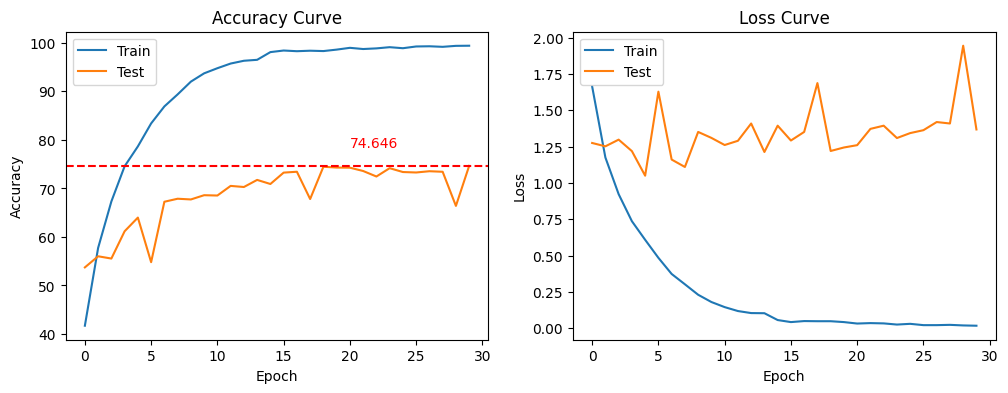

In [45]:
draw_training_summary(filepath = 'shadow_train_VGG.summary')